In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
import numpy as np
import cv2
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

/Users/ConCa/Documents/DeepLearning/Assignment/LSTM/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Phần Xử Lý Dữ Liệu

In [25]:
#Get Data
# Đường dẫn đến thư mục chứa dữ liệu
base_path = 'data'  # Thay đổi thành đường dẫn thực tế đến thư mục 'data'
actions = ['up', 'right', 'left', 'down', 'auto']  # Các hành động

# Khởi tạo danh sách để lưu trữ dữ liệu
data = []
labels = []

# Duyệt qua từng hành động
for action in actions:
    action_path = os.path.join(base_path, action)
    print(action_path)
    folders = os.listdir(action_path)
    
    # folders = folders[:200]
    print(len(folders))
    
    # Duyệt qua từng folder con chứa các frame
    for folder in folders:
        folder_path = os.path.join(action_path, folder)
        images = []
        
        # Đọc 10 ảnh trong folder con
        for filename in sorted(os.listdir(folder_path))[:10]:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))
            # Thêm ảnh vào danh sách
            images.append(img)
        
        if len(images) == 10:
            data.append(images)
            labels.append(action)

# Chuyển đổi danh sách thành numpy array
data_array = np.expand_dims(np.array(data), axis=-1)
labels_array = np.array(labels)

# Kiểm tra kích thước dữ liệu
print(data_array.shape)  # Nên in ra (n, 10, 64, 64, 1)
print(labels_array.shape)  # Nên in ra (n,)


data/up
640
data/right
536
data/left
536
data/down
517
data/auto
918
(3147, 10, 64, 64, 1)
(3147,)


In [3]:
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

y = to_categorical(np.array([label_map[y] for y in labels_array]), num_classes=5)
print(y.shape)

{'up': 0, 'right': 1, 'left': 2, 'down': 3, 'auto': 4}
(1000, 5)


In [4]:
# Số lượng nhãn hành động
num_classes = 5  # các nhãn hành động "up," "down," "right," "auto"
sequence_length = 10 #độ dài chuỗi video (số khung hình cho mỗi video)

# Model đầu tiên

In [5]:
model = Sequential()

# Các lớp CNN để trích xuất đặc trưng không gian
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(10, 64, 64, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(GlobalAveragePooling2D()))  

# Thêm LSTM
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))

# Lớp Dense để phân loại
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

/Users/ConCa/Documents/DeepLearning/Assignment/LSTM/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-11-03 16:32:04.489427: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-03 16:32:04.489446: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-11-03 16:32:04.489448: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-11-03 16:32:04.489465: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-03 16:32:04.489477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created Tenso

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 62, 62, 16) │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 31, 31, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 29, 29, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 14, 14, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 12, 12, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,717 (639.52 KB)

 Trainable params: 163,717 (639.52 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_array, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

(800, 10, 64, 64, 1)
(200, 10, 64, 64, 1)


In [8]:
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
model_name = current_datetime + "_model_1.keras"
model.save(model_name)

In [9]:
checkpoint_callback = ModelCheckpoint(filepath=model_name , monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='max')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2 , callbacks = [checkpoint_callback , early_stopping_callback] ,  batch_size=64)

Epoch 1/100


2024-11-03 16:32:05.745930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 517ms/step - accuracy: 0.2125 - loss: 7.6490 - val_accuracy: 0.2500 - val_loss: 8.5883
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.1993 - loss: 4.4650 - val_accuracy: 0.1813 - val_loss: 1.6262
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step - accuracy: 0.1928 - loss: 1.6191 - val_accuracy: 0.1688 - val_loss: 1.6142
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.2144 - loss: 1.6089 - val_accuracy: 0.1688 - val_loss: 1.6190
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.1901 - loss: 1.6137 - val_accuracy: 0.2562 - val_loss: 1.6092
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 379ms/step - accuracy: 0.1986 - loss: 1.6092 - val_accuracy: 0.1688 - val_loss: 1.6093
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 0.2142 - loss: 1.6093 - val_accuracy: 0.1688 - val_loss: 1.6100
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.1993 - loss: 1.6085 - val_accuracy: 0.1688

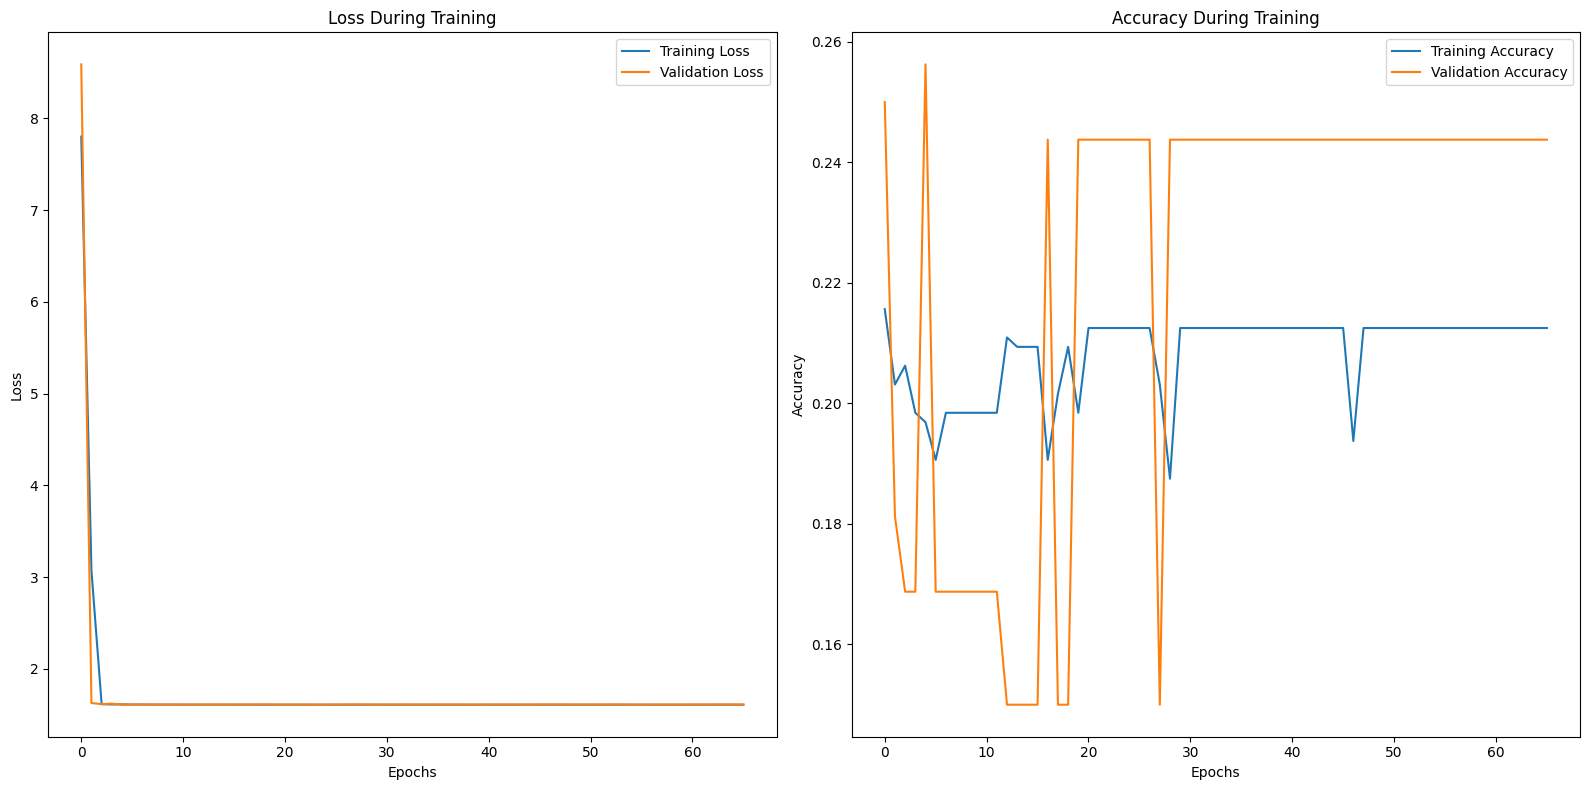

In [10]:
# Plot the loss and accuracy graphs together
plt.figure(figsize=(16, 8))

# Plot the loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
score = model.evaluate(X_test, y_test)

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.0993 - loss: 1.6244
Test loss:  1.6203429698944092
Test accuracy:  0.125


In [12]:
# Convert both y_test and y_pred to single-label format if they are one-hot encoded
if y_test.ndim > 1:
    y_true = np.argmax(y_test, axis=1)  # Convert to single-label format
else:
    y_true = y_test

# Ensure predictions are in single-label format
y_pred = np.argmax(model.predict(X_test), axis=1) if model.predict(X_test).ndim > 1 else model.predict(X_test)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Accuracy: 0.1250
Precision: 0.0156
Recall: 0.1250
F1-Score: 0.0278
[[ 0  0  0 34  0]
 [ 0  0  0 53  0]
 [ 0  0  0 42  0]
 [ 0  0  0 25  0]
 [ 0  0  0 46  0]]


/Users/ConCa/Documents/DeepLearning/Assignment/LSTM/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


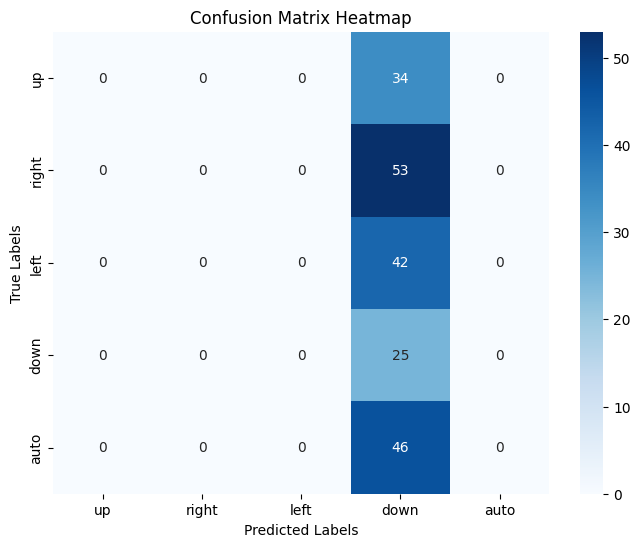

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Model thứ 2

In [14]:
model = Sequential()

# Lớp ConvLSTM2D đầu tiên
model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                     data_format='channels_last', recurrent_dropout=0.2,
                     return_sequences=True, input_shape=(10, 64, 64, 1)))

# Bọc MaxPooling2D trong TimeDistributed
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.15)))

# Lớp ConvLSTM2D thứ hai
model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh',
                     data_format='channels_last', recurrent_dropout=0.2,
                     return_sequences=True))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.15)))

# Lớp ConvLSTM2D thứ ba
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh',
                     data_format='channels_last', recurrent_dropout=0.2,
                     return_sequences=True))

model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.15)))

# Lớp ConvLSTM2D thứ tư
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='tanh',
                     data_format='channels_last', recurrent_dropout=0.2,
                     return_sequences=False))  # Không trả về chuỗi để chuẩn bị làm phẳng

model.add(Dropout(0.15))

# Làm phẳng đầu ra để chuẩn bị cho lớp Dense
model.add(Flatten())

# Lớp Dense cuối cùng với softmax để phân loại
model.add(Dense(num_classes, activation='softmax'))
# Hiển thị cấu trúc mô hình
model.summary()

/Users/ConCa/Documents/DeepLearning/Assignment/LSTM/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 10, 62, 62, 8)  │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 31, 31, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 31, 31, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 10, 29, 29, 16) │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 10, 15, 15, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 10, 15, 15, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 10, 13, 13, 32) │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 7, 7, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 7, 7, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 5, 5, 64)       │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         8,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,381 (1.15 MB)

 Trainable params: 301,381 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_array, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

(800, 10, 64, 64, 1)
(200, 10, 64, 64, 1)


In [17]:
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
model_name = current_datetime + "_model_2.keras"
model.save(model_name)

In [18]:
checkpoint_callback = ModelCheckpoint(filepath=model_name , monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='max')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# Huấn luyện mô hìnhhistory = model.fit(X_train, y_train, epochs=100, validation_split=0.2 , callbacks = [checkpoint_callback , early_stopping_callback] ,  batch_size=64)

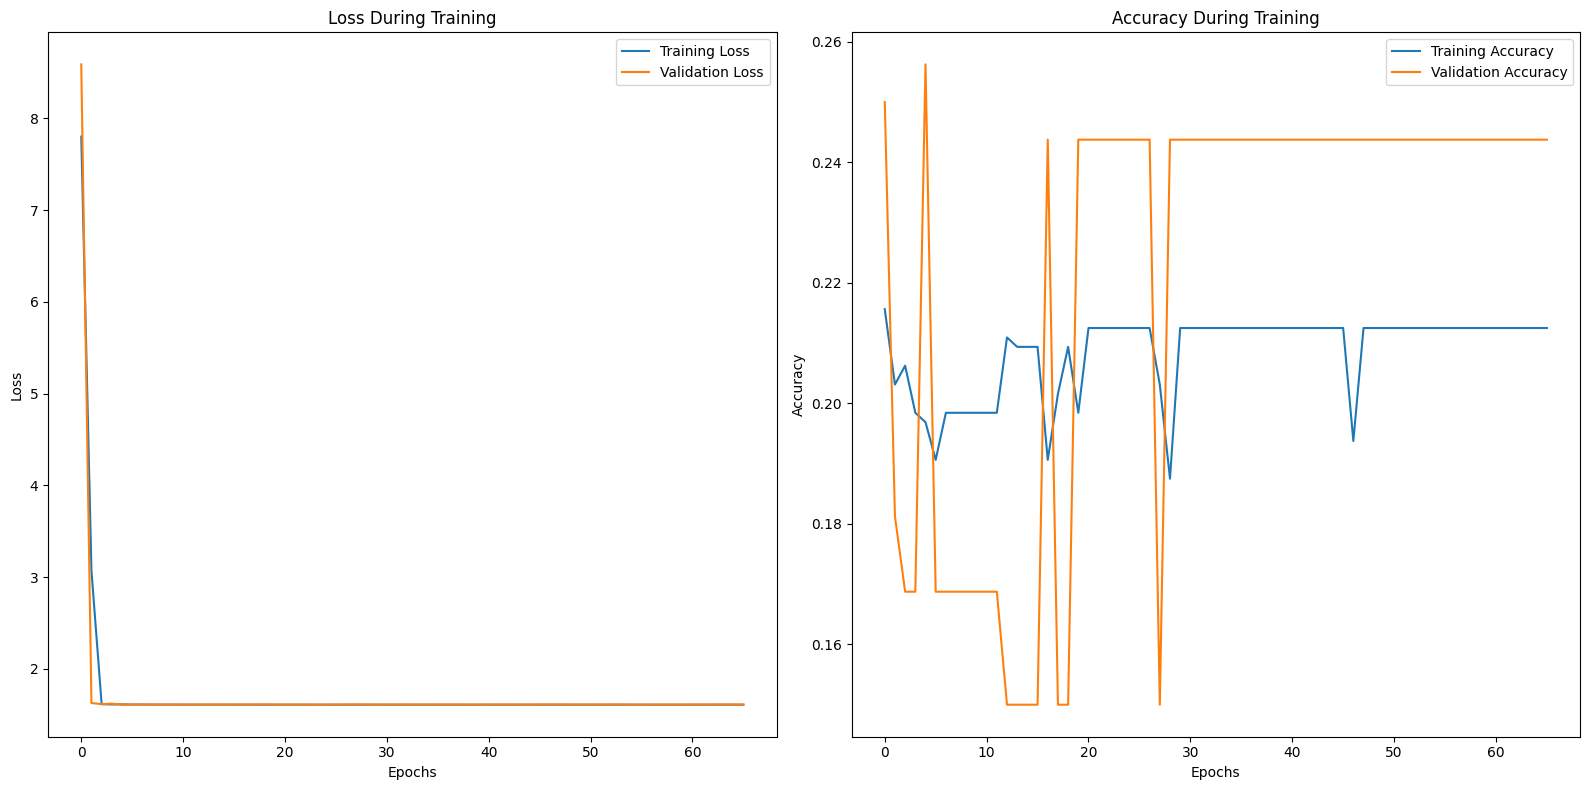

In [19]:
# Plot the loss and accuracy graphs together
plt.figure(figsize=(16, 8))

# Plot the loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
score = model.evaluate(X_test, y_test)

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.1721 - loss: 1.6104
Test loss:  1.6089756488800049
Test accuracy:  0.19499999284744263


In [21]:
# Convert both y_test and y_pred to single-label format if they are one-hot encoded
if y_test.ndim > 1:
    y_true = np.argmax(y_test, axis=1)  # Convert to single-label format
else:
    y_true = y_test

# Ensure predictions are in single-label format
y_pred = np.argmax(model.predict(X_test), axis=1) if model.predict(X_test).ndim > 1 else model.predict(X_test)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Accuracy: 0.1950
Precision: 0.1572
Recall: 0.1950
F1-Score: 0.0842
[[ 3  0  0 38  0]
 [ 1  0  0 38  0]
 [ 0  0  0 38  0]
 [ 1  0  0 36  0]
 [ 0  0  0 45  0]]


/Users/ConCa/Documents/DeepLearning/Assignment/LSTM/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


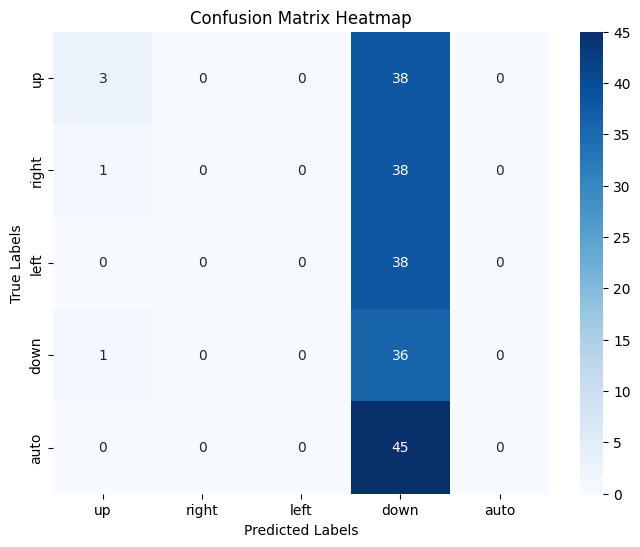

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()